<a href="https://colab.research.google.com/github/cab1000/lab4-data-repository-Franyel1/blob/main/Copy_of_LabAnalysis3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As in other assignments, this first code block is meant to set things up. **Below, modify the ```!git clone``` line so that the url points to your own data repository.**



In [1]:
# necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import scipy.optimize
import itertools,operator
import copy
from sklearn.utils import Bunch

# MODIFY THIS LINE SO THAT THE URL POINTS TO YOUR DATA REPOSITORY
!git clone https://github.com/NYU-IEP-2022-3-Classroom/lab3-data-repository-cab1000

#this line makes sure you followed the direction above; if you see 20 copies of "you didn't change the directory to match your name!" that means you need to update the data repository name and clone again
#delete my data repository (use folder icon on the left) or you will get this message again
if os.path.isdir('lab3-data-repository-mgershow'):
  for i in range(20):
    print ("You didn't change the directory to match your name!")

Cloning into 'lab3-data-repository-cab1000'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 28 (delta 3), reused 25 (delta 1), pack-reused 0
Unpacking objects: 100% (28/28), done.


These functions are needed to load the data and do a little pre-processing. Run the cell, but you don't need to change anything

In [ ]:
def findAngleFiles (startdir):
  #angleFiles = findAngleFiles(startdir)
  # input stardir: path to top level directory (e.g. data_repository/large bob)
  # output angleFiles: array with paths to angle files  
  #https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
  #https://www.kite.com/python/answers/how-to-search-for-specific-files-in-subdirectories-in-python

  angleFiles = sorted(glob.glob(startdir + '/**/*_angle.txt'))
  return (angleFiles)

# fitting an exponential
# exponential has two parameters, the y-intercept (a) and the
# exponential multiplier constant (b which for our purposes is -1/tau)
# uses cauchy loss function to reduce the influence of outliers
# inputs: x,y - numpy arrays
# outputs: a: fit value of y(0)
#          b: fit value of exonent
#          fity: a * e^(bx) 
def fitExponentialCauchyLoss(x,y):
  xx = x - np.min(x)
  yy = y / np.max(y)
  res = scipy.optimize.least_squares(lambda p : p[0]*np.exp(p[1] * xx)-yy,  (1, -1/max(xx)), loss = 'cauchy')
  a = res.x[0]
  b = res.x[1]
  a = a*np.max(y)*np.exp(-b*np.min(x))
  return (a,b, a*np.exp(b*x))



# load angle file and do some minor processing
# inputs: filepath - path of the file
# outputs: bunch object with fields
# number crossing number since start of experiment (a full period is 2 crossings)
# time time of crossing since start of experiment (resolution = 1us, accuracy unknown)
# majaxis major axis (in mm) from fitter
# minaxis minor axis (in mm) from fitter
# theta angle of major axis (in radians) relative to x-axis, from fitter
# slope slope of the voltage vs. time trace (in V/s) at time of crossing --  proportional to the total energy of the bob
# dnamplitude denoised amplitude (```sqrt(majaxis**2 + minaxis**2)```) (in mm)  found by fitting the amplitude to a decaying exponential using a cost-function that discards outliers
# dnmajaxis denoised major axis (see fit amplitude) (in mm)
# dnslope denoised slope (in V/s)
# filename name of the file the experiment was loaded from

def loadAngleFile(filepath, maxTime = 10000000):
  number, time, majaxis, minaxis, theta, slope = np.loadtxt(filepath, skiprows = 1, unpack = True)
  _,_,fitamplitude = fitExponentialCauchyLoss(time-time[0],np.sqrt(minaxis**2 + majaxis**2))
  _,_,fitmajaxis = fitExponentialCauchyLoss(time-time[0],majaxis)
  _,_,fitslope = fitExponentialCauchyLoss(time-time[0],slope)
  
  return(Bunch(number=number-number[0],time=time-time[0],majaxis=majaxis,dnamplitude=fitamplitude,minaxis=minaxis,theta=theta,slope=slope,dnmajaxis=fitmajaxis, dnslope=fitslope,filename=filepath))
  
def trimExperiment(oldexpt, timerange):
  expt = copy.copy(oldexpt)
  valid = np.logical_and(expt.time >= np.min(timerange), expt.time <= np.max(timerange))
  expt.time = expt.time[valid]
  expt.time = expt.time - expt.time[0]
  expt.number = expt.number[valid]
  expt.number = expt.number - expt.number[0]
  expt.majaxis = expt.majaxis[valid]
  expt.minaxis = expt.minaxis[valid]
  expt.theta = expt.theta[valid]
  expt.slope = expt.slope[valid] 
  _,_,expt.dnamplitude = fitExponentialCauchyLoss(expt.time,np.sqrt(expt.minaxis**2 + expt.majaxis**2))
  _,_,expt.dnmajaxis = fitExponentialCauchyLoss(expt.time,expt.majaxis)
  _,_,expt.dnslope = fitExponentialCauchyLoss(expt.time,expt.slope)
  return expt


##Analyze the data you collected using the crossing counter panel
1. Below, enter the rms amplitude and the period for each measurement. Note that if you made measurements on multiple days, *you cannot simply combine them.* Repeat the analysis for both days separately
1. Calcualte the length of your pendulum using $L = g*(T/(2 \pi))^2$ and g = 9802 mm/s$^2$ so that 
1. Make a scatter plot of the period vs. $(a/L)^2$ 
1. Use ```np.polyfit(___,___,1)``` to fit the period to a line of the form $T = T_0 + m (a/L)^2$ and plot the result on the same axes. If you write `p = np.polyfit...)`, then `p[0]` is m and `p[1]` is T
1. According to our model, $T_0/m$ should equal 16. Print your result for this value.

176.6037171379975


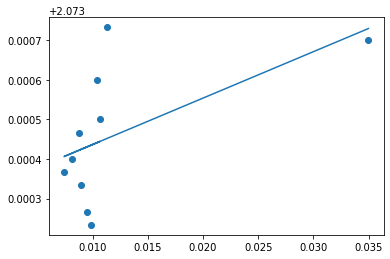

In [ ]:
#enter the amplitude and periods in the same order, so that period[0] is the period of the measurement with amp[0], period[1] is the period of the measurement with amp[1] etc
amp = np.array([199.673, 113.521, 108.622, 104.12, 99.9987,96.009, 91.9082, 110.27, 105.745, 100.952]) #you fill in this list
period = np.array([62.211, 62.212, 62.208, 62.198, 62.204,62.202, 62.201, 62.205, 62.197, 62.2]) / 30 #you fill in this list 

T = np.sum(period) / 10
a = np.sum(amp) / 10
L = 9802 * ((T / (2 * np.pi)) ** 2)

# make a plot of period (y-axis) vs. (a/L)^2 (x-axis). Hint: store (a/L)^2 in a variable - you'll use it later
#YOUR CODE HERE

diff = (amp / L) ** 2
plt.scatter(diff, period )

#fit a line period = T_0 + m * (a/L)^2 using np.polyfit
#YOUR CODE HERE

p = np.polyfit(diff, period, 1)
x = (p[0] *diff) + p[1]
plt.plot(diff, x)

#plot the fit line on top of the data
#YOUR CODE HERE

#print T_0/m
print(p[1]/ p[0])


**load the data from disk**

below is code to load the data from a set of experiments (or just one). you provide the name of the directory that contains all the timestamped directories and it does the rest. 

You should be able to understand all the code below

**edit the first line below**

In [ ]:
##CHANGE LINE BELOW##
startdir = 'lab3-data-repository-cab1000' #change to your data directory (folder containing date stamped folders)

angleFiles = findAngleFiles(startdir)
print('found {} data files'.format(len(angleFiles)))
expt = [loadAngleFile(af) for af in angleFiles]
print('loaded {} data files'.format(len(angleFiles)))


found 3 data files
loaded 3 data files


After the data is loaded, it will be stored in a list of "bunch objects" called expt. You can access the data this way:



```
expt[0].time #time of each crossing for the first experiment minus the original time
expt[0].fitamplitude #denoised amplitude for each crossing, for the first experiment
expt[1].filename #the filename of the second experiment etc.
```

The valid fields you can find use are

1. ```number``` crossing number since start of experiment (a full period is 2 crossings)
1. ```time``` time of crossing since start of experiment (resolution = 1us, accuracy unknown)
1. ```majaxis``` major axis (in mm) from fitter
1. ```minaxis``` minor axis (in mm) from fitter
1. ```theta``` angle of major axis (in radians) relative to x-axis, from fitter
1. ```slope``` slope of the voltage vs. time trace (in V/s) at time of crossing --  proportional to the total energy of the bob
1. ```dnamplitude``` denoised amplitude (```sqrt(majaxis**2 + minaxis**2)```) (in mm)  found by fitting the amplitude to a decaying exponential using a cost-function that discards outliers
1. ```dnmajaxis``` denoised major axis (see fit amplitude) (in mm)
1. ```dnslope``` denoised slope (in V/s)
1. ```filename``` name of the file the experiment was loaded from

For one experiment (of your choice), **plot the major axis (from the fitter) vs. time and the denoised major axis vs time** on the same axes.



Title the plot with the filename

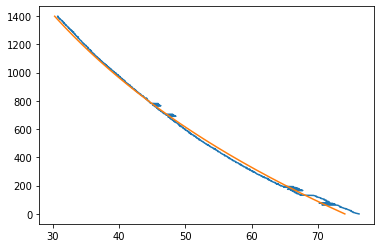

In [ ]:
plt.plot(expt[0].majaxis, expt[0].time, expt[0].dnmajaxis, expt[0].time)

```trimExperiment(expt,timerange)``` will trim the experiment to a specific time range you indicate and then refit the data, for instance

```newexpt = trimExperiment(expt,(60,660))``` 

will return a new structure that has only the data from 60 seconds after the start of the experiments to 660 seconds after the start

you can use ```trimExperiment``` to clean off any ugly bits at the start or end of the experiment if you need to. 

Use ```trimExperiment``` to create a new experiment structure (```newexpt```) containing the middle 10 minutes (from 300 to 900 seconds) of your chosen experiment (e.g. ```expt[0]```), and plot the major axis and denoised major axis vs. time as before 

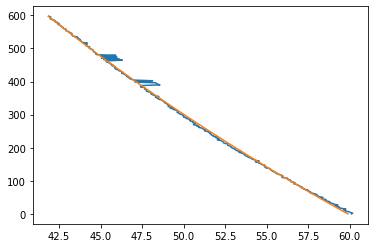

In [ ]:
newexpt = trimExperiment(expt[0], (300,900))
plt.plot(newexpt.majaxis, newexpt.time, newexpt.dnmajaxis, newexpt.time)

#OK here is where you start doing all the work!

```np.gradient``` estimates the derivative of a function using second order accurate differences

$g_i = 0.5 * (f_{i + 1} - f_{i-1})$

except at the boundaries

$g_0 = f_1 - f_0$ and $g_{n-1} = g_{n-1} - g_{n-2}$

The chief advantage of using ```np.gradient``` over ```np.diff```, which just takes the difference between successive points is that ```np.grad``` returns an array that's the same size as the original array

For a dataset of your choice:

1. Trim the experiment if you need to in order to remove problematic starts or ends
1. Calculate the period by taking the gradient of the crossing time (e.g. ```np.gradient(expt[0].time)```)
1. Plot the period vs. time
1. If there are outliers (e.g. due to a missed crossing, you get a period of 3 seconds instead of 2 seconds), then remove them as follows:
  1. Calculate the median period using ```np.median```
  2. Find all the periods within 10 ms of the median value (```valid = np.abs(period - medianperiod) < 0.01```)
  3. Create new time, amplitude, and period variables using only the `valid' values
    
       1. ```time = expt[0].time[valid]```
       1. ```dnamplitude = expt[0].dnamplitude[valid]```
       1.  etc.
  1. Plot the period vs. time for the valid data on a new set of axes 


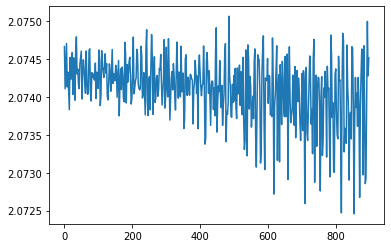

In [ ]:
#expt[0] is cleanest
newexpt = trimExperiment(expt[0], (300,1200))

T = np.gradient(newexpt.time)
plt.plot(newexpt.time, T)


Test the prediction $T = T_0(1 + \frac{1}{16} \frac{a^2}{L^2})$

If your data had outliers in the periods, then use the dataset with the outliers removed that you calculated above

1. Calculate $L$ **in mm** using $g = 9802$ mm/s$^2$ and the median period from your measurements above
1. Calculate $a^2/L^2$ using the denoised amplitude (which is also in mm)
1. Use ```np.polyfit``` to fit the period to an equation of the form $T = T_0 + m*a^2/L^2$ (note that if you store the result as ```p = np.polyfit(...```, then ```p[0]``` is m and ```p[1]``` is $T_0$.
1. According to our model, $T_0/m$ should equal 16. Print your result for this value
1. Do a 1 parameter fit to the model prediction $T = T_0(1 + \frac{1}{16} a^2/L^2)$. 
  1. Since $\frac{1}{16} a^2/L^2 \ll 1$, you can write $T_0 = T(1 - \frac{1}{16} a^2/L^2)$
  1. The average value of $T(1 - \frac{1}{16} a^2/L^2)$ is therefore the best estimate of $T_0$. 
  1. Use this best estimate to find the predicted period $T = T_0(1 + \frac{1}{16} a^2/L^2)$
1. Plot the period vs. time, the value of the period from the np.polyfit result vs. time, and the value from the one-parameter fit, on the same axes
1. Add a legend to the plot that says "data," "$T = \_\_(1 + {1}/{\_\_} \;\; a^2/L^2)$," and "model". Fill in the blanks using your fit results to 3 significant digits.
1. On a second figure, plot the residuals (period - your polyfit result) vs. time. ylabel `residuals', xlabel 'time'
1. On a third figure, plot $T/T_0 - 1$ vs. $a^2/L^2$ along with the line predicted by your fit result. 
1. On a fourth figure, plot the residuals vs denoised amplitude. ylabel residuals, xlabel 'amplitude'
1. On a fifth figure, make a histogram of the residuals with 100 bins spaced evenly from -4 sigma to 4 sigma. Title it with the standard deviation (in mm, to 2 decimal places) of the residuals. 
1. Calculate a gaussian distribution at the location of the histogram bins using the mean (shoule be 0) and standard deviation of the residuals. Scale this distribution so that its sum is the same as the number of residuals. Plot this gaussian vs. the bins on the same axes as the histogram

8.62406475106946


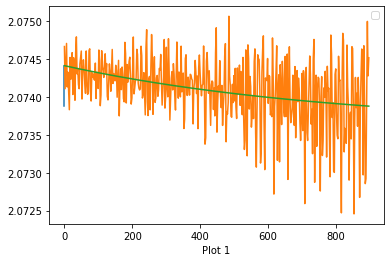

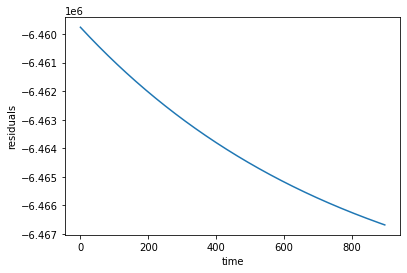

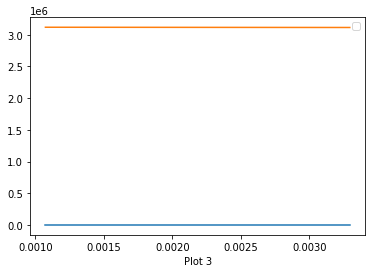

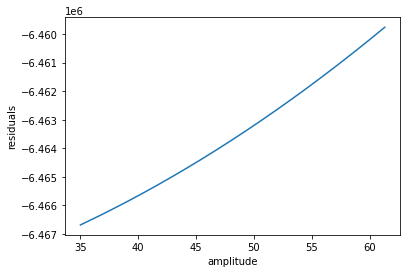

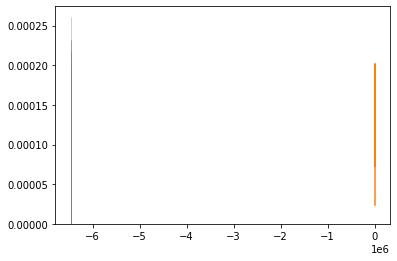

In [ ]:
y = np.gradient(newexpt.time)
Period = np.median(y)
l = 9802 * ((Period / (2 * np.pi))**2)
x = (newexpt.dnamplitude ** 2) / (l ** 2)

P = np.polyfit(x,y,1)
z = (P[0] * x) + P[1]
plt.plot(x,z)
plt.legend()
plt.xlabel('Plot 1')

print(P[1] / P[0])

T0 = y * ( 1 - ((1 /16) * x))
T0_mean = np.mean(T0)

T_Final = T0_mean * ( 1 + ((1 /16) * x))

One_fit = np.polyfit(T_Final, newexpt.time, 1)
fit = One_fit[1] + One_fit[0]*x

plt.plot( newexpt.time, y, newexpt.time, z)
plt.show()

residuals = y - fit
plt.plot( newexpt.time, residuals)
plt.xlabel('time')
plt.ylabel('residuals')
plt.show()

b = (y / T_Final) - 1
plt.plot(x, b, x, (fit/ T_Final) - 1)
plt.legend()
plt.xlabel('Plot 3')
plt.show()

plt.plot(newexpt.dnamplitude, residuals )
plt.xlabel('amplitude')
plt.ylabel('residuals')
plt.show()

sigma = np.std(residuals)
mean = np.mean(residuals)

plt.hist(residuals, bins = 100, range = [mean - (4 * sigma), mean+ (4 * sigma)], density = True, color = 'green', alpha = .5, edgecolor = 'grey', linewidth = .75)
plt.plot((1 / (sigma * np.sqrt(2 * np.pi))) * (np.exp((-(x - mean) ** 2) / ( 2 * sigma **2))))
plt.plot((1 / np.sqrt( 2 * np.pi * (sigma **2)))* np.exp(-.5 * ((residuals - mean)**2)/ (sigma ** 2)))
plt.show()

if you have more than one data set, you can do them all without too much extra work,

```
for e in expt:
  #all the code you wrote before, just change expt[0] to e
  plt.show()
  ```


#QUESTIONS

1. To what extent are your data consistent/inconsistent with the simulation you did last week? How does your fit to the data agree with/differ from the one-parameter model fit?

1. Based on your observation of the temporal structure and the histogram of the residuals, do you think these errors can be modeled as independent gaussian noise?

1. If you did multiple experiments, how much do the fit parameters vary between measurements? Would it surprise you more to find that $T_0$ varied or that $T_0/m$ varied?

1. I would argue that the denoised amplitude has very little error. Would you agree or disagree? Why? Why can't we do a similar denoising on the period?